### Фрагменты кода из методички (редактированы для ДЗ в некотрых местах)

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Загрузим один из "игрушечных" датасетов из sklearn.

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

Разделим выборку на обучающую и тестовую

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [4]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

In [5]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Напишем функцию для вычисления точности

In [6]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Построим график распределения классов.

In [7]:
def get_graph(X_train, y_train, k, knn_func):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
    cmap = ListedColormap(['red', 'green', 'blue'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn_func(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [8]:
k = 3
y_pred = knn(X_train, y_train, X_test, k)
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
k = 5
y_pred = knn(X_train, y_train, X_test, k)
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
k = 10
y_pred = knn(X_train, y_train, X_test, k)
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 3: 0.733
Точность алгоритма при k = 5: 0.867
Точность алгоритма при k = 10: 0.833


В качестве метрики расстояния будем использовать евклидово расстояние, функция для которого была написана ранее. В качестве центроидов выберем первые k элементов датасета. Реализуем основной цикл алгоритма.

In [9]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

Напишем функцию для визуализации кластеров

In [10]:
def visualize(centroids, classes):
   
    plt.figure(figsize=(7,7))
    plt.title(f'k={len(classes)}')
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        x = np.array(classes[class_item])
        plt.scatter(x[:,0], x[:,1])
            
    plt.show()

# 1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.


In [11]:
def knn_w(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        # Добавил вес
        sum_dist = sum([d[0] for d in sorted(test_distances)][0:k])
        for i, d in enumerate(sorted(test_distances)[0:k]):
            classes[d[1]] += d[0]/sum_dist 
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [12]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)
print(f'Точность алгоритма при k = {k}, без учета весов: {accuracy(y_pred, y_test):.3f}')

y_pred_w = knn_w(X_train, y_train, X_test, k)
print(f'Точность алгоритма при k = {k}, с  учетом весов: {accuracy(y_pred_w, y_test):.3f}')

Точность алгоритма при k = 5, без учета весов: 0.867
Точность алгоритма при k = 5, с  учетом весов: 0.900


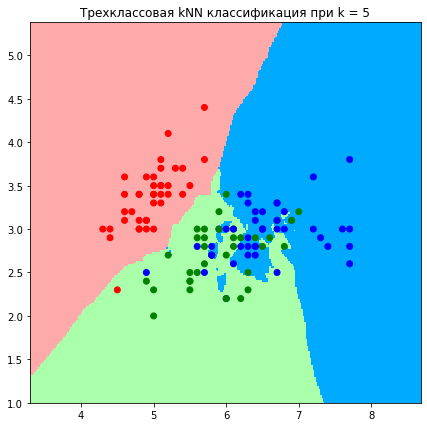

In [13]:

get_graph(X_train, y_train, k, knn)

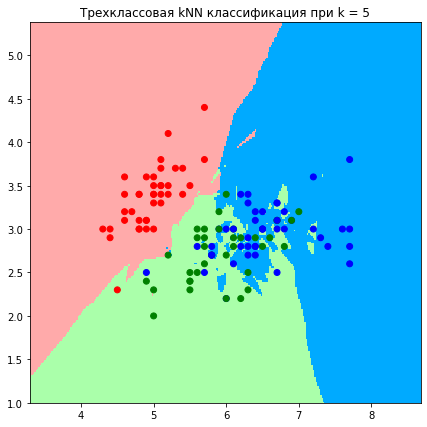

In [14]:
get_graph(X_train, y_train, k, knn_w)

# 2*. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

среднее квадратичное внутрикластерное расстояние.
$$\sum_{k=1}^{K}\frac{1}{|k|}\sum_{i=1}^{l}[a(x_{i})=k]\rho^{2}(x_{i}, c_{k}),$$

In [15]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, random_state=1)

In [16]:
# определим максимальное количество итераций
max_iterations = 10

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

In [17]:
def cc_metric(centroids, clusters):
    metric = 0
    for k in clusters:
        metric_k = 0
        for point in clusters[k]:
            metric_k += e_metrics(*(point, centroids[k])) ** 2
        metric += metric_k/len(clusters[k])
    return metric

In [18]:
ks = list(range(1,11))
results = [kmeans(X, k, max_iterations, min_distance) for k in ks]
metrics = [cc_metric(*result) for result in results]

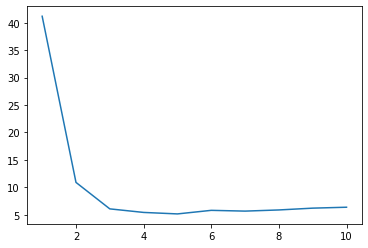

In [19]:
plt.plot(ks,metrics)

Методом локтя по полученному графику можно определить, что оптимальное число кластеров - 3 шт.

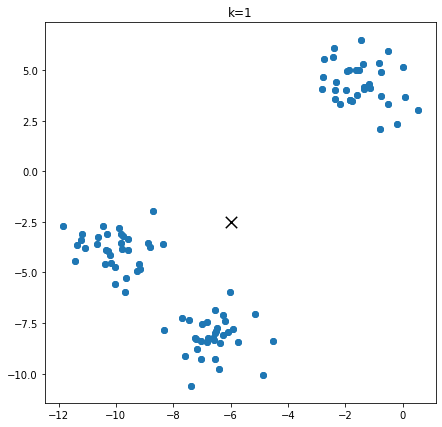

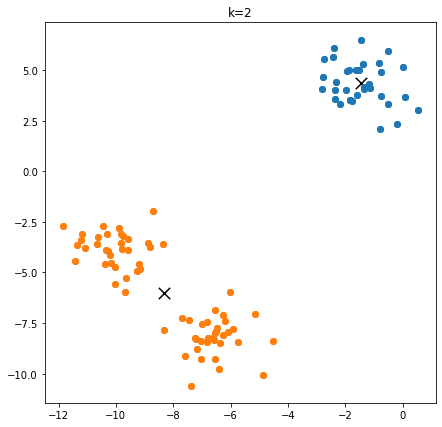

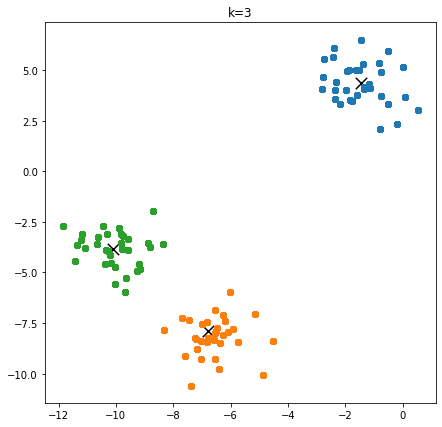

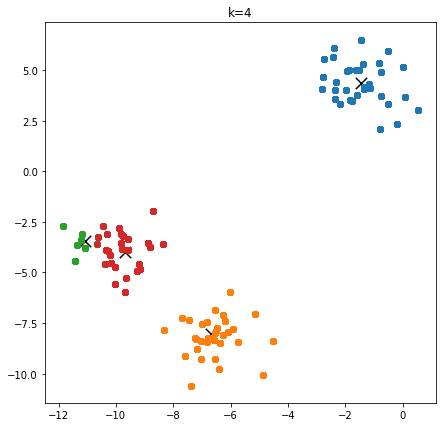

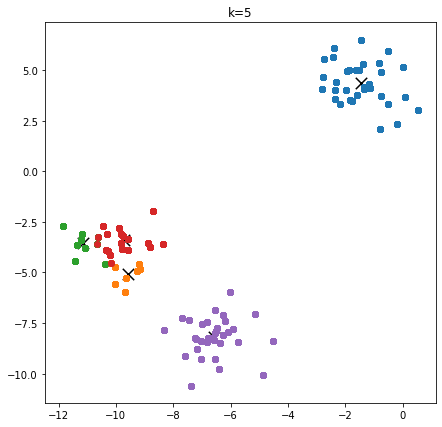

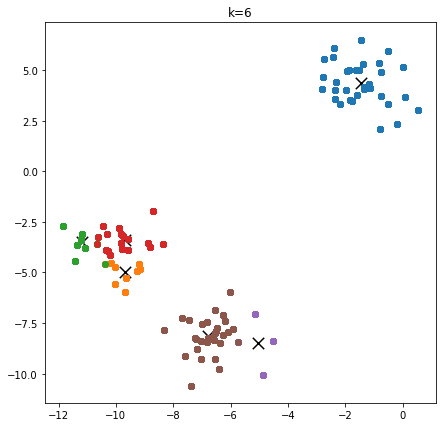

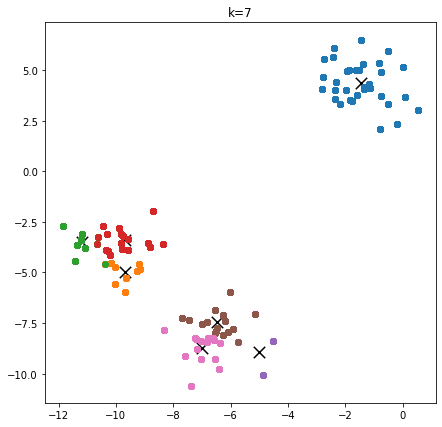

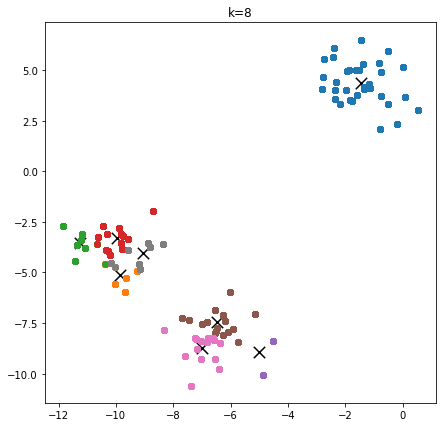

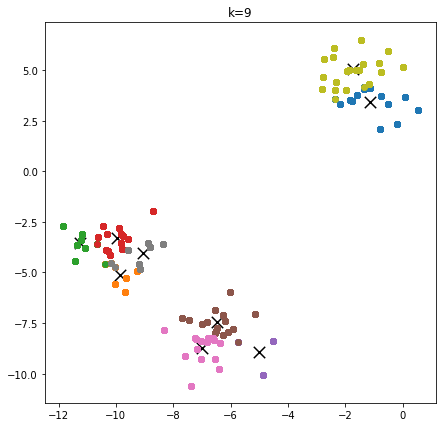

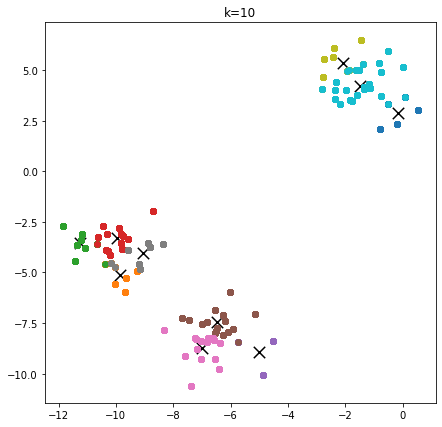

In [20]:
for result in results:
    visualize(*result) 